In [1]:
'''
This notebook calculates average annual loss from the HazImp output of multiple recurrence interval scenarios.

It also creates multiple graphs and imports and spatialises the data in ArcGIS Pro.

Depending on the formatting, file structure and the naming convention of the HazImp AEP output files, 
references and variables throughout this notebook will need to be changed.

Please review the entire notebook to edit variables and commenting to ensure that the notebook will run as intended.
'''

import os
os.environ["CRYPTOGRAPHY_OPENSSL_NO_LEGACY"]="yes"
import arcgis
from arcgis.gis import GIS
gis = GIS()
import arcpy
from arcpy import metadata as md
import pandas as pd
import numpy as np
from scipy.integrate import simpson
from matplotlib import pyplot as plt
import seaborn as sns
from os.path import join as pjoin
sns.set_style('whitegrid')
sns.set_context('talk')

In [32]:
#Define the attributes which represent the impact (loss) values. These values must be written as they are in the HazImp output attribute tables.
LOSSFIELD = "structural_mean"
LOSSFIELD2 = "structural_loss_sum"

#Define the location of the input data (HazImp output), the location to save the output tables and graphs, and the ArcGIS output.
BASEPATH = r"X:\georisk\HaRIA_B_Wind\projects\acs\2. DATA\1. Work Unit Assessment\NWRA\impact\AEP\LGA\ACT"
#BASEPATH = r"X:\georisk\HaRIA_B_Wind\projects\qfes_swha\data\DRAFT DATA STRUCTURES\1. Work Unit Assessment\SOUTH EAST QUEENSLAND\Risk\risk_pp_baseline"
OUTPATH = r"X:\georisk\HaRIA_B_Wind\projects\acs\2. DATA\1. Work Unit Assessment\NWRA\impact\AAL\LGA"
table_out_path = r"X:\georisk\HaRIA_B_Wind\projects\acs\2. DATA\1. Work Unit Assessment\NWRA\NWRA_Table_LGA.gdb"
feature_out_path = r"X:\georisk\HaRIA_B_Wind\projects\acs\2. DATA\1. Work Unit Assessment\NWRA\NWRA_AAL_LGA.gdb"

#Define the location of the feature class or shapefile of the aggregate boundaries matching the aggregation used in HazImp.
agg_boundary_loc = r"X:\georisk\HaRIA_B_Wind\projects\acs\2. DATA\1. Work Unit Assessment\NWRA\NWRA.gdb\extents\SA2_2021_AUST"

#The state name variable is the name of the state or scenario being run, this is used to label graphs and name output files.
state_name = "ACT"

#Extracting the recurrence intervals.

#The method of doing this may change depending on where the recurrence intervals can be referenced from.

#In this example recurrence interval is referenced from the file names in the input path,
#any occurrence of '_agg' is removed, the first two characters (RP) are removed, and the last 4 characters are removed (the .filetype).
#Duplicates are removed and what is left is a list of recurrence intervals.
#Recurrence interval is then converted from a string to an integer and then sorted.
ARIS = os.listdir(BASEPATH)
ARIS = ([s.replace('_SA2_agg', '') for s in ARIS])
ARIS = [sub[2: -4] for sub in ARIS]
ARIS = list(dict.fromkeys(ARIS))
ARIS = list(map(int, ARIS))
ARIS = sorted(ARIS)

#In some instances, you may need to add a 1 to the beginning of the list of recurrence intervals in order for calculation to be made.
#ARIS = [1] + ARIS

In [33]:
#Create an empty dataframe (one for each LOSSFIELD) with SA2 CODE and the recurrence intervals as the columns.
lossdf = pd.DataFrame(columns=["SA2_CODE", *ARIS])
lossdf2 = pd.DataFrame(columns=["SA2_CODE", *ARIS])

#Define the function for calculating aep (probability) from ari (recurrence interval).
def probability(ari):
    """Return an annual probability given a return period"""
    aep = 1.0 - np.exp(-1.0/ari)
    return aep

### The following section of the notebook calculates AAL and creates graphs for a single region


In [34]:
#Define the location of a file which contains all SA2 codes (this can be any aggregated HazImp output file).
SA2_CODE_ref = os.path.join(BASEPATH, f"RP1_SA2_agg.csv")
#Define the location of all aggregated HazImp output files using a general format.
file_format = os.path.join(BASEPATH, "RP{}_SA2_agg.csv")

#Define a function which calculates AAL stats and saves these to a csv.
def AAL_loss_stats(df,state_name,lossfield,outpath):
    Max = df['AAL'].max()
    Min = df['AAL'].min()
    Mean = df['AAL'].mean()
    Median = df['AAL'].median()
    Std = df['AAL'].std()
    loss_stats = pd.DataFrame({"Dataset": [f"{lossfield}_{state_name}"],
                               "Max": [Max],
                               "Min": [Min],
                               "Mean": [Mean],
                               "Median": [Median],
                               "Std": [Std]})
    loss_stats.set_index("Dataset", inplace=True)
    loss_stats.to_csv(pjoin(outpath,
                    f"{lossfield}_{state_name}_AAL_loss_stats.csv"))

Calculations using Structural loss ratio (LOSSFIELD)

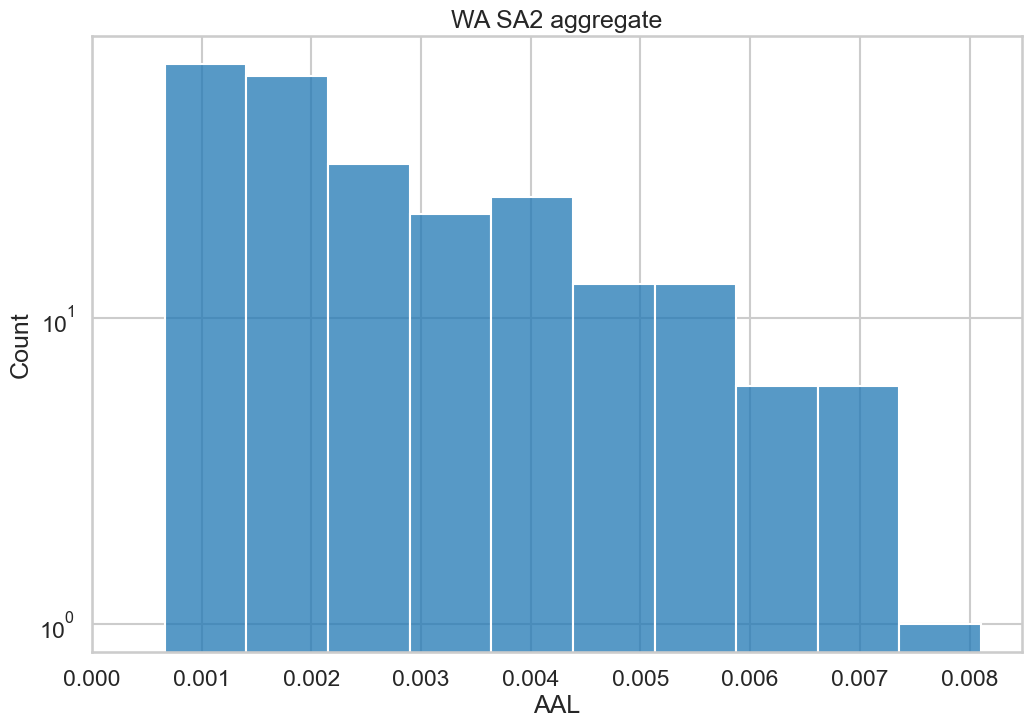

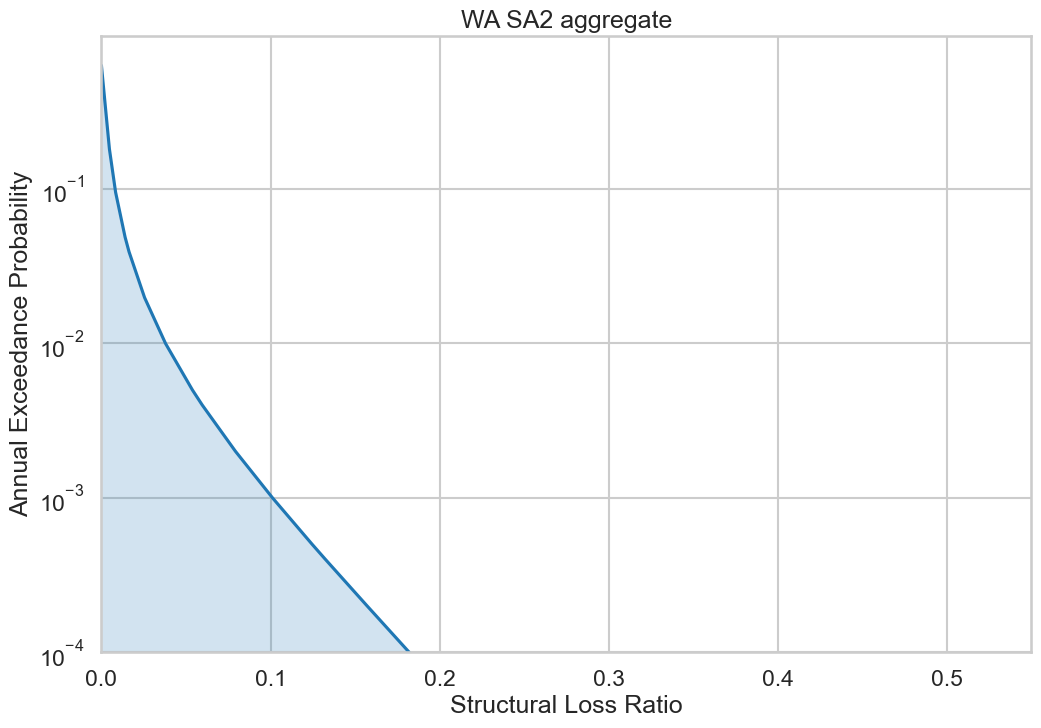

In [35]:
#Set SA2 code as the index for the loss dataframe.
firstdf = pd.read_csv(SA2_CODE_ref)
lossdf['SA2_CODE'] = firstdf['SA2_CODE']
lossdf.set_index('SA2_CODE', inplace=True)

#Import all ari output flies and append loss value (LOSSFIELD) to loss dataframe.
for ARI in ARIS:
    if ARI == 1: continue
    tmpdf = pd.read_csv(file_format.format(ARI))
    tmpdf.set_index('SA2_CODE', inplace=True)
    lossdf = lossdf.join(tmpdf[LOSSFIELD])
    lossdf[ARI] = lossdf[LOSSFIELD]
    lossdf.drop(LOSSFIELD, axis=1, inplace=True)
lossdf[1] = 0

#Calculate average annual loss and save .csv. This df includes SA2_CODE, loss value for all ARIS and AAL.
aeps = probability(np.array(lossdf.columns.to_list()))
lossdf['AAL'] = (lossdf).apply(simpson, axis=1, x=-1*aeps)
#When importing a table into ArcGIS Pro the column names cannot begin with a number (even if the number is set as a string).
#Add a string to the beginning of the recurrence interval values and define the location of this table for later reference.
lossdf.columns = lossdf.columns.map(str)
lossdf = lossdf.rename(columns={c: 'RP' + c for c in lossdf.columns if c not in ['SA2_CODE', 'AAL']})
lossdf.to_csv(pjoin(OUTPATH, f"{LOSSFIELD}_{state_name}_SA2.csv"))
ArcGIS_table_loc = pjoin(OUTPATH, f"{LOSSFIELD}_{state_name}_SA2.csv")
#Save AEP calculations.
aeps_save = pd.DataFrame(aeps)
aeps_save.to_csv(pjoin(OUTPATH, f"{LOSSFIELD}_{state_name}_aeps.csv"))
#Calculate and save loss stats.
lossdf_stats = AAL_loss_stats(lossdf, state_name, LOSSFIELD, OUTPATH)

#Plot histogram of AAL (structural loss ratio) counts.
#SA2 agg
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(lossdf['AAL'], ax=ax)
ax.set_yscale('log')
plt.xlim(left=0)
ax.set_xlabel('AAL')
ax.set_ylabel('Count')
ax.set_title(f'{state_name} SA2 aggregate')
plt.savefig(pjoin(OUTPATH,
                f"{LOSSFIELD}_{state_name}_SA2"))

#Finding mean of structural loss ratio mean to create AAL prob plot.
#SA2 agg
lossdf = lossdf.drop(['AAL'], axis=1)
lossdf = lossdf.mean(axis=0)


#Creating AAL prob plot.
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=lossdf, y=aeps, ax=ax)
ax.set_yscale('log')
plt.xlim([0,0.55])
plt.ylim(bottom=0.0001)
ax.set_xlabel('Structural Loss Ratio')
ax.set_ylabel('Annual Exceedance Probability')
ax.set_title(f'{state_name} SA2 aggregate')
ax.fill_between(lossdf, aeps, alpha=0.2)
plt.savefig(pjoin(OUTPATH,
                f"{LOSSFIELD}_{state_name}_SA2_probability_loss"))

Calculations using Structural loss (AUD) (LOSSFIELD2)

In [ ]:
#Repeat the previous steps for other LOSSFIELDS

firstdf2 = firstdf
lossdf2['SA2_CODE'] = firstdf2['SA2_CODE']
lossdf2.set_index('SA2_CODE', inplace=True)

for ARI in ARIS:
    if ARI == 1: continue
    tmpdf2 = pd.read_csv(os.path.join(BASEPATH, f"RP{ARI:d}_SA2_agg.csv"))
    tmpdf2.set_index('SA2_CODE', inplace=True)
    lossdf2 = lossdf2.join(tmpdf2[LOSSFIELD2])
    lossdf2[ARI] = lossdf2[LOSSFIELD2]
    lossdf2.drop(LOSSFIELD2, axis=1, inplace=True)
lossdf2[1] = 0

aeps = probability(np.array(lossdf2.columns.to_list()))
lossdf2['AAL'] = lossdf2.apply(simpson, axis=1, x=-1*aeps)
lossdf2.columns = lossdf2.columns.map(str)
lossdf2 = lossdf2.rename(columns={c: 'RP' + c for c in lossdf2.columns if c not in ['SA2_CODE', 'AAL']})
lossdf2.to_csv(pjoin(OUTPATH, f"{LOSSFIELD2}_{state_name}_SA2.csv"))
ArcGIS_table_loc2 = pjoin(OUTPATH, f"{LOSSFIELD2}_{state_name}_SA2.csv")
lossdf2 = lossdf2.div(1000000) #structural loss values are very high, so divide by 1 mill to turn values from $ to million$
lossdf2_stats = AAL_loss_stats(lossdf2, state_name, f'{LOSSFIELD2}_(Millions)' , OUTPATH)

fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(lossdf2['AAL'], ax=ax)
ax.set_yscale('log')
plt.xlim(left=0)
ax.set_xlabel('AAL (Millions)')
ax.set_ylabel('Count')
ax.set_title(f'{state_name} SA2 aggregate')
plt.savefig(pjoin(OUTPATH,
                f"{LOSSFIELD2}_{state_name}_SA2"))

lossdf2 = lossdf2.drop(['AAL'], axis=1)
lossdf2 = lossdf2.sum(axis=0)
lossdf2 = lossdf2.div(1000)

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=lossdf2, y=aeps, ax=ax)
ax.set_yscale('log')
plt.xlim(left=0)
plt.ylim(bottom=0.0001)
ax.set_xlabel('Structural Loss Value (Billions)')
ax.set_ylabel('Annual Exceedance Probability')
ax.set_title(f'{state_name} SA2 aggregate')
ax.fill_between(lossdf2, aeps, alpha=0.2)
plt.savefig(pjoin(OUTPATH,
                f"{LOSSFIELD2}_SA2_probability_loss"))

### The following functions and examples can be used when you want to calculate AAL and create graphs for smaller areas within the area of interest
e.g. calculating AAL by LGA


In [7]:
# #Define the location of a file which contains all SA2 codes (this can be any aggregated HazImp output file).
# SA2_CODE_ref2 = os.path.join(BASEPATH, f"2\windspeed_2_yr_agg.csv")
# #Define the location of a file which contains all LGA codes (this can be any unit level HazImp output file).
# LGA_CODE_ref = os.path.join(BASEPATH, f"2\windspeed_2_yr.csv")
# #Define the location of all aggregated HazImp output files using a general format.
# file_format2 = os.path.join(BASEPATH, "{}\windspeed_{}_yr_agg.csv")

# #Create a dataframe which contains the names of the LGAs for each SA2.
# df = pd.read_csv(LGA_CODE_ref)
# df.drop(df.columns.difference(['SA2_CODE','LGA_CODE','LGA_NAME']), axis=1, inplace=True)
# df.drop_duplicates(subset=['SA2_CODE'], inplace=True) #(SA2 boundaries and LGA boundaries do not always align, just keep one instance of SA2 code).
# df.set_index('SA2_CODE', inplace=True)

# #Define the LGAs of Interest and remove data which is not within those LGAs.
# LGAs_6 = ['Noosa (S)', 'Sunshine Coast (R)', 'Moreton Bay (R)', 'Brisbane (C)', 'Gold Coast (C)', 'Redland (C)'] #Edit this with the names of interest.
# LGAs = df[df['LGA_NAME'].isin(LGAs_6)]
# LGAs = LGAs.drop_duplicates(subset=['LGA_NAME'])
# LGAs = LGAs.reset_index()
# LGAs = LGAs.drop(['SA2_CODE'],axis=1)
# LGA_codes = df[df['LGA_NAME'].isin(LGAs_6)]

In [8]:
# #Define functions which create plots.

# #In all of the following definitions, state_name could be LGA name, this is just used to title the plot and name the output.
# #Type can be used if multiple versions of scenarios are run, e.g. retrofit scenarios. This variable is used to create a separate output folder for different runs.
# #If it is not needed it can be removed.

# #AAL stats, this version of AAL stats is slightly different because of the differences in the folder structure of the input data and the naming convention of the output data used.
# def AAL_loss_stats2(df,state_name,lossfield,outpath,type):
#     Max = df['AAL'].max()
#     Min = df['AAL'].min()
#     Mean = df['AAL'].mean()
#     Median = df['AAL'].median()
#     Std = df['AAL'].std()
#     loss_stats = pd.DataFrame({"Dataset": [f"{lossfield}_{state_name}"],
#                                "Max": [Max],
#                                "Min": [Min],
#                                "Mean": [Mean],
#                                "Median": [Median],
#                                "Std": [Std]})
#     loss_stats.set_index("Dataset", inplace=True)
#     loss_stats.to_csv(pjoin(outpath,type,
#                     f"{lossfield}_{state_name}_loss_stats.csv"))

# #Plotaal_count_ratio plots a histogram of AAL (structural loss ratio) counts 
# def plotaal_count_ratio(df,state_name,lossfield,outpath,type):
#     med_loss = df['AAL'].median()
#     fig, ax = plt.subplots(figsize=(12, 8))
#     sns.histplot(df['AAL'], ax=ax)
#     plt.xlim([0,0.008]) #You might need to change this depending on your data
#     ax.set_yscale('log')
#     ax.set_xlabel('AAL')
#     ax.set_ylabel('Count')
#     plt.axvline(med_loss, color='k', linestyle='dashed', linewidth=1.5)
#     ax.set_title(state_name)
#     plt.savefig(pjoin(outpath, type,
#                     f"{lossfield}_{state_name}_AAL.png"))

# #Plotaal_count_loss plots a histogram of AAL (structural loss AUD) counts 
# def plotaal_count_loss(df,state_name,lossfield,outpath,type):
#     fig, ax = plt.subplots(figsize=(12, 8))
#     sns.histplot(df['AAL'], ax=ax)
#     plt.xlim(left=0)
#     ax.set_yscale('log')
#     ax.set_xlabel('AAL (Millions)')
#     ax.set_ylabel('Count')
#     ax.set_title(state_name)
#     plt.savefig(pjoin(outpath, type,
#                     f"{lossfield}_{state_name}_AAL.png"))
          
# #Expected loss plot for AAL structural loss ratio
# def plotaal_prob_ratio(df,state_name,lossfield,outpath,type):
#     fig, ax = plt.subplots(figsize=(12, 8))
#     sns.lineplot(x=df, y=aeps, ax=ax)
#     ax.set_yscale('log')
#     plt.xlim([0,0.55])
#     plt.ylim(bottom=0.0001)
#     ax.set_xlabel('Structural Loss Ratio')
#     ax.set_ylabel('Annual Exceedance Probability')
#     ax.set_title(state_name)
#     ax.fill_between(df, aeps, alpha=0.2)
#     plt.savefig(pjoin(outpath, type,
#                     f"{lossfield}_{state_name}_probability_loss.png"))

# # Expected loss plot for AAL structural loss AUD (change the x label if you are not using billions)
# def plotaal_prob_loss(df,state_name,lossfield,outpath,type):
#     fig, ax = plt.subplots(figsize=(12, 8))
#     sns.lineplot(x=df, y=aeps, ax=ax)
#     ax.set_yscale('log')
#     plt.xlim([0,95])
#     plt.ylim(bottom=0.0001)
#     ax.set_xlabel('Structural Loss Value (Billions)')
#     ax.set_ylabel('Annual Exceedance Probability')
#     ax.fill_between(df, aeps, alpha=0.2)
#     ax.set_title(state_name)
#     plt.savefig(pjoin(outpath, type,
#                     f"{lossfield}_{state_name}_probability_loss.png"))

In [9]:
# #Set SA2 code for loss dataframe
# firstdf = pd.read_csv(SA2_CODE_ref2)
# lossdf['SA2_CODE'] = firstdf['SA2_CODE_']
# lossdf.set_index('SA2_CODE', inplace=True)

# #Import all ari output flies and append loss value (LOSSFIELD)
# for ARI in ARIS:
#     if ARI == 1: continue
#     tmpdf = pd.read_csv(file_format2.format(ARI, ARI))
#     tmpdf.set_index('SA2_CODE_', inplace=True)
#     lossdf = lossdf.join(tmpdf[LOSSFIELD])
#     lossdf[ARI] = lossdf[LOSSFIELD]
#     lossdf.drop(LOSSFIELD, axis=1, inplace=True)
# lossdf[1] = 0

# #Calculate the average annual loss
# aeps = probability(np.array(lossdf.columns.to_list()))
# lossdf['AAL'] = (lossdf).apply(simpson, axis=1, x=-1*aeps)
# lossdf.to_csv(pjoin(OUTPATH, state_name, f"{LOSSFIELD}_SA2.csv"))
# ArcGIS_table_loc = pjoin(OUTPATH, state_name, f"{LOSSFIELD}_SA2.csv")
# #Save AEP calculations.
# aeps_save = pd.DataFrame(aeps)
# aeps_save.to_csv(pjoin(OUTPATH, state_name, f"{LOSSFIELD}_aeps.csv"))
# #Calculate and save loss stats.
# lossdf_stats = AAL_loss_stats2(lossdf,state_name,LOSSFIELD,OUTPATH,state_name)

# #Plot histogram of AAL (structural loss ratio) counts for the entire region (not breaking down by LGA yet).
# #SA2 agg
# fig, ax = plt.subplots(figsize=(12, 8))
# sns.histplot(lossdf['AAL'], ax=ax)
# ax.set_yscale('log')
# plt.xlim(left=0)
# ax.set_xlabel('AAL')
# ax.set_ylabel('Count')
# ax.set_title('SA2 aggregate')
# plt.savefig(pjoin(OUTPATH, state_name,
#                 f"{LOSSFIELD}_SA2"))

# #Groupby LGA code to plot histogram as LGA agg (rather than SA2 agg which is what is used by default).
# lossdf_LGA = lossdf.join(df)
# lossdf_LGA = lossdf_LGA.drop(['LGA_NAME','AAL'], axis=1)
# fields = ['LGA_CODE']
# lossdf_LGA = lossdf_LGA.groupby(fields).\
#     mean()
# lossdf_LGA['AAL'] = (lossdf_LGA).apply(simpson, axis=1, x=-1*aeps)
# lossdf_LGA.to_csv(pjoin(OUTPATH, state_name, f"{LOSSFIELD}_LGA.csv"))

# #Plot histogram of AAL (structural loss ratio) counts for the entire region.
# #LGA agg
# fig, ax = plt.subplots(figsize=(12, 8))
# sns.histplot(lossdf_LGA['AAL'], ax=ax)
# plt.xlim(left=0)
# ax.set_xlabel('AAL')
# ax.set_ylabel('Count')
# ax.set_title('LGA aggregate')
# plt.savefig(pjoin(OUTPATH, state_name,
#                 f"{LOSSFIELD}_LGA"))

# #Break the data down by LGA.
# #Create stats.csv, count plot and prob plot for each LGA of interest.
# for index, LGA_code in LGAs.iterrows():
#     LGAdf = df.loc[df['LGA_CODE'] == LGA_code['LGA_CODE']]
#     LGAname = LGA_code['LGA_NAME']
#     LGAname = LGAname[:-4]
#     LGAname = LGAname.replace(" ", "_")
#     lossdf4 = lossdf.merge(LGAdf, left_index=True, right_index=True)
#     lossdf4.columns = lossdf4.columns.map(str)
#     lossdf4 = lossdf4.rename(columns={c: 'RP' + c for c in lossdf4.columns if c not in ['SA2_CODE', 'AAL', 'LGA_CODE', 'LGA_NAME']})
#     lossdf4.to_csv(pjoin(OUTPATH, state_name, f"{LOSSFIELD}_{LGAname}_SA2.csv"))
#     AAL_loss_stats2(lossdf4, LGAname, LOSSFIELD, OUTPATH, state_name)
#     plotaal_count_ratio(lossdf4, LGAname, LOSSFIELD, OUTPATH, state_name)
#     lossdf4 = lossdf4.drop(['AAL','LGA_CODE','LGA_NAME'], axis=1)
#     lossdf4 = lossdf4.mean(axis=0)
#     plotaal_prob_ratio(lossdf4, LGAname, LOSSFIELD, OUTPATH, state_name)

# file_format3 = os.path.join(OUTPATH, state_name, "{}_{}_SA2.csv") #General format of aggregated HazImp output.

# #Find mean of structural loss ratio mean to create AAL prob plot.
# #SA2 agg
# lossdf = lossdf.mean(axis=0)
# lossdf = lossdf.drop(['AAL'])

# #Create AAL prob plot for entire dataset.
# #SA2 agg
# fig, ax = plt.subplots(figsize=(12, 8))
# sns.lineplot(x=lossdf, y=aeps, ax=ax)
# ax.set_yscale('log')
# plt.xlim([0,0.75])
# plt.ylim(bottom=0.0001)
# ax.set_xlabel('Structural Loss Ratio')
# ax.set_ylabel('Annual Probability')
# ax.set_title('SA2 aggregate')
# ax.fill_between(lossdf, aeps, alpha=0.2)
# plt.savefig(pjoin(OUTPATH, state_name,
#                 f"{LOSSFIELD}_SA2_probability_loss"))

# #Find mean of structural loss ratio mean to create AAL prob plot.
# #LGA agg
# lossdf_LGA = lossdf_LGA.mean(axis=0)
# lossdf_LGA = lossdf_LGA.drop(['AAL'])

# #Create AAL prob plot for entire dataset.
# #LGA agg
# fig, ax = plt.subplots(figsize=(12, 8))
# sns.lineplot(x=lossdf_LGA, y=aeps, ax=ax)
# ax.set_yscale('log')
# plt.xlim([0,0.75])
# plt.ylim(bottom=0.0001)
# ax.set_xlabel('Structural Loss Ratio')
# ax.set_ylabel('Annual Probability')
# ax.set_title('LGA aggregate')
# ax.fill_between(lossdf_LGA, aeps, alpha=0.2)
# plt.savefig(pjoin(OUTPATH, state_name,
#                 f"{LOSSFIELD}_LGA_probability_loss"))

### This section imports AAL tables into ArcGIS Pro and spatialises them

This is formatted to work for the entire dataset.

In [36]:
#Define metadata.
#Metadata text can be defined here. {} indicates that a variable will be used in these locations.
#Variables are defined further down.
#If you would like to change the variables or add variables you will need to edit the .format(variable) function.

#Aggregated table metadata.
agg_table_title = '{}' # name of table (agg_table_name)
agg_table_tags = 'NWRA, ACS, risk, impact'
agg_table_summary = 'Raw tabulated {} SA2 aggregated average annual loss (AAL) values.' # state name
agg_table_description = 'Raw, tabulated HazImp calculations of average structural loss ratio for all recurrence intervals, \
and average annual loss (AAL) for {}, aggregated to SA2 code (2021). Raw HazImp data location {}' # state name, location of input table in directory
agg_table_credits = 'Commonwealth of Australia (Geoscience Australia)'
agg_table_accessConstraints = 'Creative Commons Attribution 4.0 International Licence. \
<a href="https://creativecommons.org/licenses/by/4.0/">https://creativecommons.org/licenses/by/4.0/</a>'

#Aggregated feature class metadata.
agg_feature_title = '{}' # name of feature class
agg_feature_tags = agg_table_tags
agg_feature_summary = '{} SA2 aggregated average annual loss (AAL) values.' # state name
agg_feature_description = 'HazImp calculations of average annual loss (AAL) in {}, aggregated to SA2 code (2021). Spatialised \
using raw HazImp output from {}' # state name, recurrence interval years, location of input table in directory
agg_feature_credits = agg_table_credits
agg_feature_accessConstraints = agg_table_accessConstraints

#Define names for ArcGIS output.
agg_table_name = LOSSFIELD + '_' + state_name + '_SA2_AAL_table'
agg_feature_name = LOSSFIELD + '_' + state_name + '_SA2_AAL'

#Import table into ArcGIS.
arcpy.conversion.ExportTable(in_table = ArcGIS_table_loc,
                             out_table = os.path.join(table_out_path, agg_table_name))

#Create copy of SA2 boundaries.
arcpy.conversion.ExportFeatures(in_features = agg_boundary_loc,
                                out_features = os.path.join(feature_out_path, agg_feature_name))

#Add a field to the hazImp agg table and assign the SA2 CODE values. 
#(SA2 in the hazImp output is a double but it is text in the boundaries feature class, they need to be the same in order for the join to work).
arcpy.management.AddField(in_table = os.path.join(table_out_path, agg_table_name),
                          field_name = 'SA2_CODE21',
                          field_type = 'TEXT')
arcpy.management.CalculateField(in_table = os.path.join(table_out_path, agg_table_name),
                                field = 'SA2_CODE21',
                                expression = '!SA2_CODE!',
                                expression_type = 'PYTHON3')

#Join the aggregated hazImp output table with the SA2 boundaries.
arcpy.management.JoinField(in_data = os.path.join(feature_out_path, agg_feature_name),
                           in_field = 'SA2_CODE21',
                           join_table = os.path.join(table_out_path, agg_table_name),
                           join_field = 'SA2_CODE21')

#The copy of the SA2 boundaries we used is a national dataset but the data we are joining is not national. 
#Use update cursor to delete rows (SA2s) which have null values.
#This will leave only the SA2s in the state which have residential building (and loss) data.
with arcpy.da.UpdateCursor(os.path.join(feature_out_path, agg_feature_name), 'AAL', 'AAL is NULL') as cursor:
    for row in cursor:
            cursor.deleteRow()

#Create a metadata file and add predefined text for the agg table
agg_table_md =  md.Metadata()
agg_table_md.title = agg_table_title.format(agg_table_name)
agg_table_md.tags = agg_table_tags
agg_table_md.summary = agg_table_summary.format(state_name)
agg_table_md.description = agg_table_description.format(state_name, ArcGIS_table_loc)
agg_table_md.credits = agg_table_credits
agg_table_md.accessConstraints = agg_table_accessConstraints

#Select the agg table metadata and overwrite it with the predefined metadata
target_md = md.Metadata(os.path.join(table_out_path, agg_table_name))
if not target_md.isReadOnly:
       target_md.copy(agg_table_md)
       target_md.save()
            
#Create a metadata file and add predefined text for the agg feature class
agg_feature_md = md.Metadata()
agg_feature_md.title = agg_feature_title.format(agg_feature_name)
agg_feature_md.tags = agg_feature_tags
agg_feature_md.summary = agg_feature_summary.format(state_name)
agg_feature_md.description = agg_feature_description.format(state_name, ArcGIS_table_loc)
agg_feature_md.credits = agg_feature_credits
agg_feature_md.accessConstraints = agg_feature_accessConstraints

#Select the agg feature class metadata and overwrite it with the predefined metadata
target_md = md.Metadata(os.path.join(feature_out_path, agg_feature_name))
if not target_md.isReadOnly:
       target_md.copy(agg_feature_md)
       target_md.save()

 This section is formatted to create sepereate feature classes for different regions (e.g. LGAs).

In [11]:
# #Define metadata.
# #Metadata text can be defined here. {} indicates that a variable will be used in these locations.
# #Variables are defined further down.
# #If you would like to change the variables or add variables you will need to edit the .format(variable) function.

# #Aggregated table metadata.
# agg_table_title = '{}' # name of table (agg_table_name)
# agg_table_tags = 'NWRA, ACS, risk, impact'
# agg_table_summary = 'Raw tabulated {} SA2 aggregated average annual loss (AAL) values.' # LGA name
# agg_table_description = 'Raw, tabulated HazImp calculations of average structural loss ratio for all recurrence intervals, \
# and average annual loss (AAL) for {}, aggregated to SA2 code (2021). Raw HazImp data location {}' # LGA name, location of input table in directory
# agg_table_credits = 'Commonwealth of Australia (Geoscience Australia)'
# agg_table_accessConstraints = 'Creative Commons Attribution 4.0 International Licence. \
# <a href="https://creativecommons.org/licenses/by/4.0/">https://creativecommons.org/licenses/by/4.0/</a>'

# #Aggregated feature class metadata.
# agg_feature_title = '{}' # name of feature class
# agg_feature_tags = agg_table_tags
# agg_feature_summary = '{} SA2 aggregated average annual loss (AAL) values.' # state name
# agg_feature_description = 'HazImp calculations of average annual loss (AAL) in {}, aggregated to SA2 code (2021). Spatialised \
# using raw HazImp output from {}' # state name, recurrence interval years, location of input table in directory
# agg_feature_credits = agg_table_credits
# agg_feature_accessConstraints = agg_table_accessConstraints

# for LGA in LGAs_6:
#     LGAname = LGA
#     LGAname = LGAname[:-4]
#     LGA_name = LGAname
#     LGAname = LGAname.replace(" ", "_")
#     #Define names for ArcGIS output
#     agg_table_name = LOSSFIELD + '_' + LGAname + '_AAL_table'
#     agg_feature_name = LOSSFIELD + '_' + LGAname + '_AAL'
#     ArcGIS_table_loc = file_format3.format(LOSSFIELD, LGAname)
#     #Import table into ArcGIS
#     arcpy.conversion.ExportTable(in_table = ArcGIS_table_loc,
#                                  out_table = os.path.join(table_out_path, agg_table_name))
#     #Create copy of SA2 boundaries
#     arcpy.conversion.ExportFeatures(in_features = agg_boundary_loc,
#                                     out_features = os.path.join(feature_out_path, agg_feature_name))

#     #Add a field to the hazimp agg table and assign the SA2 CODE values.
#     #(SA2 in the hazimp output is a double but it is text in the boundaries feature class, they need to be the same in order for the join to work).
#     arcpy.management.AddField(in_table = os.path.join(table_out_path, agg_table_name),
#                               field_name = 'SA2_CODE21',
#                               field_type = 'TEXT')
#     arcpy.management.CalculateField(in_table = os.path.join(table_out_path, agg_table_name),
#                                     field = 'SA2_CODE21',
#                                     expression = '!SA2_CODE!',
#                                     expression_type = 'PYTHON3')

#     #Join the aggregated hazimp output table with the SA2 boundaries.
#     arcpy.management.JoinField(in_data = os.path.join(feature_out_path, agg_feature_name),
#                                in_field = 'SA2_CODE21',
#                                join_table = os.path.join(table_out_path, agg_table_name),
#                                join_field = 'SA2_CODE21')

#     #The copy of the SA2 boundaries we used is a national dataset but the data we are joining is not national.
#     #Use update cursor to delete rows (SA2s) which have null values.
#     #This will leave only the SA2s in the state which have residential building (and loss) data.
#     with arcpy.da.UpdateCursor(os.path.join(feature_out_path, agg_feature_name), 'AAL', 'AAL is NULL') as cursor:
#         for row in cursor:
#                 cursor.deleteRow()

#     #Create a metadata file and add predefined text for the agg table.
#     agg_table_md =  md.Metadata()
#     agg_table_md.title = agg_table_title.format(agg_table_name)
#     agg_table_md.tags = agg_table_tags
#     agg_table_md.summary = agg_table_summary.format(LGA_name)
#     agg_table_md.description = agg_table_description.format(LGA_name, ArcGIS_table_loc)
#     agg_table_md.credits = agg_table_credits
#     agg_table_md.accessConstraints = agg_table_accessConstraints

#     #Select the agg table metadata and overwrite it with the predefined metadata.
#     target_md = md.Metadata(os.path.join(table_out_path, agg_table_name))
#     if not target_md.isReadOnly:
#            target_md.copy(agg_table_md)
#            target_md.save()
            
#     #Create a metadata file and add predefined text for the agg feature class.
#     agg_feature_md = md.Metadata()
#     agg_feature_md.title = agg_feature_title.format(agg_feature_name)
#     agg_feature_md.tags = agg_feature_tags
#     agg_feature_md.summary = agg_feature_summary.format(LGA_name)
#     agg_feature_md.description = agg_feature_description.format(LGA_name, ArcGIS_table_loc)
#     agg_feature_md.credits = agg_feature_credits
#     agg_feature_md.accessConstraints = agg_feature_accessConstraints

#     #Select the agg feature class metadata and overwrite it with the predefined metadata.
#     target_md = md.Metadata(os.path.join(feature_out_path, agg_feature_name))
#     if not target_md.isReadOnly:
#            target_md.copy(agg_feature_md)
#            target_md.save()